In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

2025-11-11 20:38:08.870680: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 20:38:08.874181: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 20:38:08.947248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 20:38:08.948322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 20:38:10.080857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
train_dir = "../dataset/train" #passing the path with training images
test_dir = "../dataset/test"   #passing the path with testing images

In [3]:
img_size = 48 #original size of the image

In [ ]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [7]:
epochs = 5
batch_size = 64

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [9]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/5
359/359 [==============================] - 225s 621ms/step - loss: 9.3200 - accuracy: 0.1896 - val_loss: 8.7318 - val_accuracy: 0.1753
Epoch 2/5
359/359 [==============================] - 211s 587ms/step - loss: 8.2815 - accuracy: 0.2255 - val_loss: 7.6210 - val_accuracy: 0.2654
Epoch 3/5
359/359 [==============================] - 217s 605ms/step - loss: 7.3055 - accuracy: 0.2493 - val_loss: 6.6050 - val_accuracy: 0.3233
Epoch 4/5
359/359 [==============================] - 216s 602ms/step - loss: 6.3552 - accuracy: 0.2714 - val_loss: 5.7604 - val_accuracy: 0.3387
Epoch 5/5
359/359 [==============================] - 212s 589ms/step - loss: 5.4482 - accuracy: 0.3023 - val_loss: 4.9161 - val_accuracy: 0.3582


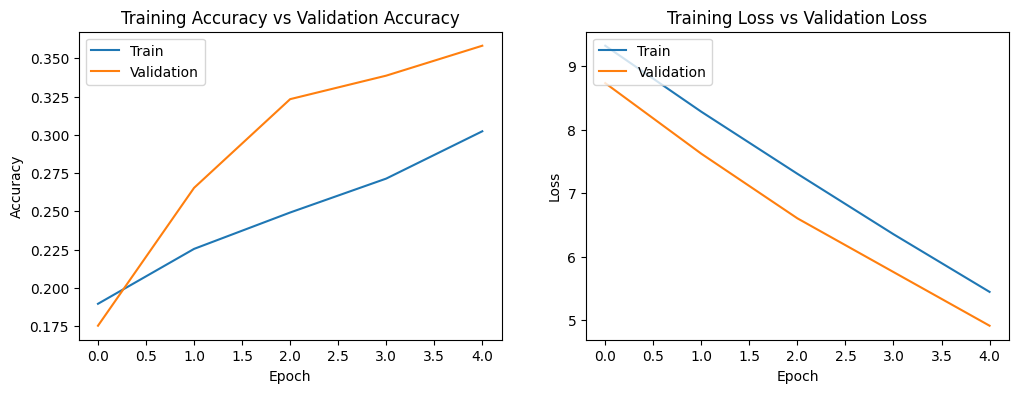

In [10]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [11]:
model.save('model_optimal.h5')

/home/cytech/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(48, 48)


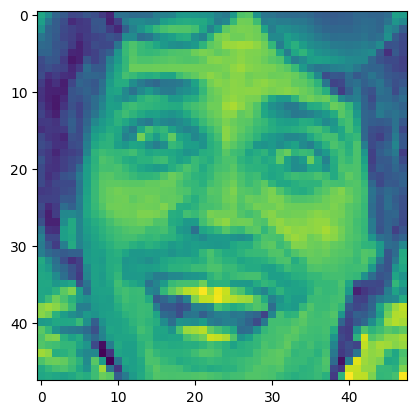

In [13]:
img = image.load_img("../dataset/test/happy/im1021.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [14]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [15]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 189ms/step
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [16]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Surprise


In [17]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 4s 170ms/step - loss: 4.9161 - accuracy: 0.3582
final train accuracy = 34.33 , validation accuracy = 35.82


In [18]:
model.save_weights('model_weights.h5')